In [1]:
from Function.Function import *
from os.path import abspath , join
from sklearn.preprocessing import normalize ,LabelEncoder,StandardScaler
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from random import shuffle
import matplotlib.pyplot  as plt
current_folder =abspath('');current_folder



'/Users/yangtao/Documents/GitHub/850-project'

# Preprocessing data

In [2]:
N_calibrate = 0.8 #  days for train
N_validation = 1 - N_calibrate # days for test
# data = pd.read_csv('Data/finalproject_training.csv')
data = pd.read_csv('Data/finalproject_training_xy.csv')

In [3]:
# the xs that was cleaned for useless price data and non number data and NONE data(first check)
data = data.loc[:,data.columns[12:]]
data = data.loc[:,(np.array(data.dtypes == 'int64') ) | (np.array(data.dtypes == 'float64') )].dropna()
# data = data.loc[:,(np.array(data.dtypes == 'int64') ) | (np.array(data.dtypes == 'float64') )].fillna(data.mean() ,axis = 0)

In [4]:
# data = data.sample(frac=0.03 )

In [5]:
# separate X and Y
X_data = data.iloc[:,:-1]
Y_data = data.iloc[:,-1]
print(X_data.shape)



#normalization or standardlization(i did normalization here)
# X_data = pd.DataFrame(normalize(X_data, axis=0) , columns = X_data.columns , index = X_data.index)
X_data = pd.DataFrame(StandardScaler().fit_transform(X_data) , columns = X_data.columns , index = X_data.index)
# calibrate and validation

X_data ,Y_data = get_data(X_data,Y_data,N_calibrate , N_validation)
X_data['calibrate']['processed'].columns
# generate data of returns direction [-1,1] 
# -1 indicate negative returns, 1 indicate positive returns
Y_data['calibrate']['direction'] = [-1 if i < 0 else 1 for i in Y_data['calibrate']['processed']]
Y_data['validation']['direction'] = [-1 if i < 0 else 1 for i in Y_data['validation']['processed']]

(2776, 71)


# Autoencoder or PCA ?

# lets do Autoencoder with nerual network first

# Construct model

In [6]:
dimension_of_input  = len(X_data['calibrate']['processed'].T) # number of stock
autoencoder = inital_model(dimension_of_input) # inital_model 具体initial的model在function文件里
# train model
# we use net difference to train model
Autoencoder_data = np.array(X_data['calibrate']['processed']) 
# we use pre-trained model with best fit to save time

autoencoder.fit(Autoencoder_data, Autoencoder_data, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)
autoencoder.save(join(current_folder,'Models/com_autoencoder_{}.h5'.format(1)))

# Predict and see what the factors is most relevent and explain most variance
# dimension reduction


In [7]:
path = join(current_folder,'Models/com_autoencoder_{}.h5'.format(1))
autoencoder = load_model(path)
predict = autoencoder.predict(Autoencoder_data) 
# use different error measure to decide which factors explain most variance

# we need to figure out what is the best error measure,?

# sum absolute relative error
communal_information = np.sum(np.absolute((Autoencoder_data - predict)),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : X_data['calibrate']['processed'].columns[ranking] })
ranks

,communal,index
0,60.117869,tfvceq
1,131.505767,atq
2,131.505767,lseq
3,138.682650,oibdpq
4,140.277309,oiadpq
...,...,...
66,1924.609410,fyearq
67,2008.134099,gsubind
68,2008.134294,gind
69,2008.162828,ggroup


### lower the communal_information,higer explaination

### you can do prediction by using autoencoder directly. i can write it down if we decide to do it

# Lets do PCA and backtest
### from here you either use pca classifier or linear regression for prediction


In [19]:
# number of factors that is used to do regression
n_factors = [*range(10,len(X_data['calibrate']['processed'].columns)//2 + 1, 5 )] [::-1]
# store mse of different method with different number of factors
mse_pca_calibration = [] # mean squared errors of pca with calibration data
mse_pca_validation = [] # mean squared errors of pca with validation data
mse_lg_calibration = [] # mean squared errors of linear regression with calibration data
mse_lg_validation = [] # mean squared errors of linear regression with validation data
for k in n_factors:
    # index of factors 
    # the top k factors combined with bottom k factors
    index = list(X_data['calibrate']['processed'].columns[ranking[:k]]) + \
                 list(X_data['calibrate']['processed'].columns[ranking[-k:]])
    # get X data
    data = X_data['calibrate']['processed'].loc[:,index]


    # using pca in LinearRegression
    X = data
    y = np.array(Y_data['calibrate']['processed'])
    pca = PCA(n_components=2) #initial model
    X_pca = pca.fit_transform(X) # pca decomposition

    model_pca = LinearRegression()# initial predicition model
    model_pca.fit(X_pca,y) # fit model

    # record mse
    mse_pca_calibration.append(mean_squared_error(model_pca.predict(X_pca),y))
    # out of sample-validation
    # get validation X data and Y data
    X_test =  np.array(X_data['validation']['processed'].loc[:,index]) 
    X_test_pca = pca.fit_transform(X_test)
    y_test = np.array(Y_data['validation']['processed'])

    # record mse(validation)
    mse_pca_validation.append(mean_squared_error(model_pca.predict(X_test_pca),y_test))

    ## compare with the performance of linear regression without PCA

    model = LinearRegression()# initial predicition model
    model.fit(X,y) # fit model
    # record mse
    mse_lg_calibration.append(mean_squared_error(model.predict(X),y)
    mse_lg_validation.append(mean_squared_error(model.predict(X_test),y_test))

In [20]:
# present mse
mse = {'mse_pca_calibration' : mse_pca_calibration, 'mse_pca_validation' : mse_pca_validation, \
                   'mse_lg_calibration' : mse_lg_calibration, 'mse_lg_validation' : mse_lg_validation}
mse_dt = pd.DataFrame(mse , index = n_factors)
mse_dt

,mse_pca_calibration,mse_pca_validation,mse_lg_calibration,mse_lg_validation
35,0.010615,0.008590,0.009825,0.015701
30,0.010615,0.008589,0.009850,0.011679
25,0.010615,0.008576,0.009912,0.012071
20,0.010615,0.008577,0.009960,0.008656
15,0.010615,0.008576,0.009986,0.008356
10,0.010438,0.009080,0.010114,0.008241


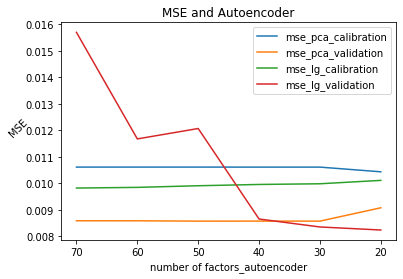

In [21]:
mse_dt.plot(use_index = False)
plt.xticks(range(len(n_factors)),np.array(n_factors)*2)
plt.xlabel('number of factors_autoencoder')
plt.ylabel('MSE',rotation = 45)
plt.title('MSE and Autoencoder')
plt.show()

In [16]:
accurcy_pca_calibrate = []
accurcy_pca_validation = []
accurcy_lg_calibrate = []
accurcy_lg_validation = []
for k in n_factors:
    index = list(X_data['calibrate']['processed'].columns[ranking[:k]]) + \
             list(X_data['calibrate']['processed'].columns[ranking[-k:]])
    data = X_data['calibrate']['processed'].loc[:,index]
    rf = LogisticRegression()
    X = data
    y = Y_data['calibrate']['direction']
    pca = PCA(n_components=2) #initial model
    X_pca = pca.fit_transform(X) # pca decomposition

    rf.fit(X_pca,y)

    accurcy_pca_calibrate.append(rf.score(X_pca,y))

    X_test =  np.array(X_data['validation']['processed'].loc[:,index]) 
    X_test_pca = pca.fit_transform(X_test)
    y_test = Y_data['validation']['direction']

    accurcy_pca_validation.append(rf.score(X_test_pca,y_test))
    
    model = LinearRegression()# initial predicition model
    model.fit(X,y)

    accurcy_lg_calibrate.append(sum(np.array([-1 if i < 0 else 1 for i in model.predict(X)]) == y )/ len(y))

    accurcy_lg_validation.append(sum(np.array([-1 if i < 0 else 1 for i in model.predict(X_test)])  == y_test )/ len(y_test))

In [17]:
accurcy_pca_validation

[0.5323741007194245,
 0.5323741007194245,
 0.5305755395683454,
 0.5305755395683454,
 0.5305755395683454,
 0.5305755395683454]

In [18]:
accurcy_lg_validation

[0.5449640287769785,
 0.5665467625899281,
 0.5701438848920863,
 0.5665467625899281,
 0.5539568345323741,
 0.5629496402877698]

0.5539568345323741
2


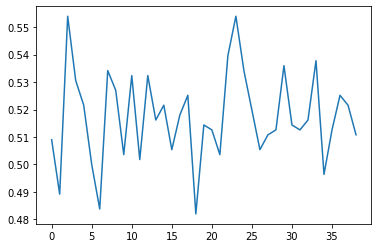

In [14]:
n_components = range(1,40,1)

k = 20
index = list(X_data['calibrate']['processed'].columns[ranking[:k]]) + \
         list(X_data['calibrate']['processed'].columns[ranking[-k:]])
data = X_data['calibrate']['processed'].loc[:,index]

X_test =  np.array(X_data['validation']['processed'].loc[:,index]) 

y_test = Y_data['validation']['direction']
accurcy_pca_calibrate = []
accurcy_pca_validation = []

for s in n_components:
    rf = RandomForestClassifier()
    X = data
    y = Y_data['calibrate']['direction']
    pca = PCA(n_components=s) #initial model
    X_pca = pca.fit_transform(X) # pca decomposition
    X_test_pca = pca.fit_transform(X_test)
    rf.fit(X_pca,y)

    accurcy_pca_calibrate.append(rf.score(X_pca,y))
    accurcy_pca_validation.append(rf.score(X_test_pca,y_test))


plt.plot(accurcy_pca_validation)



print(max(accurcy_pca_validation))
print(accurcy_pca_validation.index(max(accurcy_pca_validation)))